In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
features = pd.read_pickle('./data/features_test.pkl')
stock_data = pd.read_csv('./data/stock_data_test.csv', index_col='Unnamed: 0')

In [3]:
display(features)
display(stock_data)

{'4584.T':           feat_1      feat_2     feat_3      feat_4      feat_5      feat_6  \
 180   734.689087  123.499207  30.843113 -345.803986  433.608459 -449.363556   
 181   634.747009  103.663925  28.473894 -294.388885  373.312225 -384.783264   
 182   676.864746  112.292336  32.621391 -316.591156  401.190735 -412.538086   
 183   694.850098  118.005768  34.235714 -324.470490  412.803833 -425.951752   
 184   684.634338  116.040680  32.078613 -317.571198  406.474396 -417.737030   
 ...          ...         ...        ...         ...         ...         ...   
 1294  223.451508   39.885864  11.101674 -102.470436  138.206482 -143.450790   
 1295  230.035980   42.742805   9.579368 -105.303726  140.051514 -141.415268   
 1296  226.375488   37.585320  12.369206 -103.315849  140.573196 -144.255249   
 1297  230.569122   39.036400  13.432136 -105.590363  142.691833 -142.796387   
 1298  226.544662   41.507702  13.038601 -102.488571  138.436844 -143.210434   
 
           feat_7      feat_

,4584.T,1557.T,8789.T,1893.T,MSFT
180,661.0,28860.0,137.0,533.62700,11123.248
181,708.0,29190.0,140.0,543.87270,10875.842
182,730.0,29370.0,145.0,529.35803,10690.548
183,718.0,29630.0,144.0,547.28790,11058.452
184,732.0,29800.0,141.0,552.41077,11266.821
...,...,...,...,...,...
1294,243.0,55640.0,80.0,680.00000,41467.410
1295,241.0,55680.0,79.0,681.00000,42251.793
1296,244.0,55600.0,69.0,675.00000,41581.720
1297,241.0,55650.0,68.0,678.00000,41555.848


In [4]:
from ray.tune import register_env
from ray.rllib.models import ModelCatalog

model_name = "CustumMoldel"
env_name = "stock_trading_env"

# カスタムモデルのインポート
from MyCustomModel import MaskModel

ModelCatalog.register_custom_model(model_name, MaskModel)

# 環境クラスのインポート
from gym_stock_trading_env import StockTradingEnv

# Define a function to create the environment
def create_stock_trading_env(_):
    env = StockTradingEnv(stock_data, features)
    return env

# Register the environment
register_env(env_name, create_stock_trading_env)

c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os
import ray
from ray.rllib.algorithms.ppo import PPOConfig
from collections import defaultdict

# Initialize Ray in local mode
ray.init(ignore_reinit_error=True)

# Create PPO agent
ppo_config = PPOConfig()
ppo_config["model"]["custom_model"] = model_name

ppo_config["vf_loss_coeff"] = 0.01 # default : False
# ppo_config["lr"] = 0.00002 # default : 5e-5
ppo_agent = ppo_config.environment(env=env_name)
ppo_agent = ppo_config.build()

# Track rewards
rewards = []

# Train the agents
num_iterations = 3000

for i in range(num_iterations):
    ppo_result = ppo_agent.train()
    print(f"Iteration {i + 1}:")
    print(f"PPO: episode_reward_mean={ppo_result['episode_reward_mean']}")
    
    # Record the reward
    rewards.append(ppo_result['episode_reward_mean'])

2023-05-18 03:40:42,660	INFO worker.py:1625 -- Started a local Ray instance.
2023-05-18 03:40:44,130	INFO algorithm.py:527 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-05-18 03:40:47,074	ERROR actor_manager.py:507 -- Ray error, taking actor 1 out of service. The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=37212, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000015E2A0033D0>)
  File "python\ray\_raylet.pyx", line 877, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 881, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 821, in ray._raylet.execute_task.function_executor
  File "c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\ray\_private\function_manager.py", line 670, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\rodin\work\stock_trade\.venv\

AssertionError: Dict space element is not an instance of Space: key='avail_actions', space=[ 500  300  200  100   50   10    0  -10  -50 -100 -200 -300 -500]

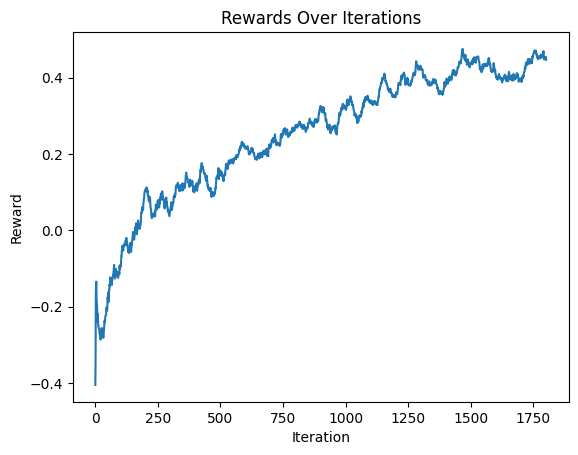

In [ ]:
modelpath = ppo_agent.save('./model')
os.makedirs(modelpath+'/fig', exist_ok=True)

# Plot rewards
plt.plot(rewards)
plt.title("Rewards Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.savefig(modelpath+'/fig/reward_over_iterations.png')
plt.show()

In [ ]:
def evaluate(agent, env):
    obs, info = env.reset(seed=42)
    terminated = False

    # Initialize data tracking
    profit_loss = defaultdict(float)
    total_profit_loss = defaultdict(float)
    stock_prices = defaultdict(list)
    transaction_volumes = defaultdict(list)
    portfolio_values = defaultdict(list)
    portfolio_stock_number = defaultdict(list)
    profit_loss_values = defaultdict(list)
    total_values = []

    # Calculate the starting portfolio value
    stocks = env.stock_data.columns
    total_value_start = env.cash + sum(env.positions[stock] * env.stock_data.loc[env.current_step, stock] for stock in stocks)
    total_values.append(total_value_start)
    portfolio_ratios = {stock: [] for stock in stocks}
    portfolio_ratios["cash"] = []

    while not terminated:
        # action = agent.compute_action(obs)
        action = agent.compute_single_action(obs, exploit=True)  # force deterministic actions
        obs, reward, terminated, _, info = env.step(action)

        # Update the profit/loss for each stock
        for i, stock in enumerate(stocks):
            stock_prices[stock].append(env.stock_data.loc[env.current_step, stock])
            transaction_volumes[stock].append(env.shares_amounts[action[i]])
            portfolio_stock_number[stock].append(env.positions[stock])
            current_value = env.positions[stock] * env.stock_data.loc[env.current_step, stock]
            portfolio_values[stock].append(current_value)
            cost = info.get(stock, {}).get('cost', 0)
            sold_value = info.get(stock, {}).get('sell_value', 0)
            profit_loss[stock] += sold_value - cost
            total_profit_loss[stock] = profit_loss[stock] + current_value
            profit_loss_values[stock].append(total_profit_loss[stock])
            
        # Update portfolio ratios
        total_value = env.cash + sum(env.positions[stock] * env.stock_data.loc[env.current_step, stock] for stock in stocks)
        for stock in stocks:
            portfolio_ratios[stock].append(portfolio_values[stock][-1] / total_value)
        portfolio_ratios["cash"].append(env.cash / total_value)


        total_value_end = env.cash + sum(env.positions[stock] * env.stock_data.loc[env.current_step, stock] for stock in stocks)
        total_values.append(total_value_end)

    # Calculate total value percentage change
    total_value_percentage_change = ((total_value_end - total_value_start) / total_value_start) * 100
    total_values_percentage = [(value / total_value_start - 1) * 100 for value in total_values]
    
    # Plot data
    for stock in stocks:
        plt.figure(figsize=(12, 9))

        plt.subplot(511)
        plt.plot(stock_prices[stock])
        plt.title(f"Price of {stock}")

        plt.subplot(512)
        plt.plot(transaction_volumes[stock])
        plt.title(f"Transaction volume of {stock}")
        
        plt.subplot(513)
        plt.plot(portfolio_stock_number[stock])
        plt.title(f"Portfolio stock number of {stock}")

        plt.subplot(514)
        plt.plot(portfolio_values[stock])
        plt.title(f"Portfolio value of {stock}")

        plt.subplot(515)
        plt.plot(profit_loss_values[stock])
        plt.title(f"Profit/Loss of {stock}")

        plt.tight_layout()
        plt.savefig(modelpath+f'/fig/{stock}_result.png')
        plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(total_values_percentage)
    plt.title("Total asset value (% change from start)")
    plt.savefig(modelpath+'/fig/asset_transition.png')
    plt.show()
    
    # Plot portfolio ratios
    plt.figure(figsize=(12, 6))

    bar_width = 0.85
    bar_l = [i+1 for i in range(len(portfolio_ratios['cash']))] 
    tick_pos = [i+(bar_width/2) for i in bar_l]

    # Create a total ratio for stacking
    total_ratio = [0] * len(portfolio_ratios['cash'])

    for stock, ratios in portfolio_ratios.items():
        plt.bar(bar_l, ratios, bottom=total_ratio, label=stock, width=bar_width)
        total_ratio = [i+j for i,j in zip(total_ratio, ratios)]

    # Here we set the x-ticks to only include every nth tick to prevent crowding.
    n = 200  # the number of steps between each tick
    plt.xticks(tick_pos[::n], range(len(portfolio_ratios['cash']))[::n])

    plt.legend()
    plt.title("Portfolio asset ratios over time")
    plt.xlabel("Time")
    plt.ylabel("Asset ratio")
    plt.savefig(modelpath+'/fig/ratio_transition.png')
    plt.show()

    return total_value_percentage_change, dict(total_profit_loss)



register_env(env_name, create_stock_trading_env)
ray.init(ignore_reinit_error=True)

# Create the environment
env = StockTradingEnv(stock_data, features)

# Create PPO agent
ppo_config = PPOConfig()
ppo_config["seed"] = 42
ppo_agent = ppo_config.environment(env=env_name)
ppo_agent = ppo_config.build()
ppo_agent.restore(modelpath)

print("\nEvaluating trained agents:")
rewards = evaluate(ppo_agent, env)
print(f"Total value percentage change: {rewards[0]}")
for stock, reward in rewards[1].items():
    print(f"PPO: {stock} profit/loss={reward}")


# Shutdown Ray
ray.shutdown()

2023-05-17 14:16:43,966	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.
2023-05-17 14:16:46,941	ERROR actor_manager.py:507 -- Ray error, taking actor 1 out of service. The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=36124, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000023E19943370>)
  File "c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\ray\rllib\utils\gym.py", line 30, in check_old_gym_env
    raise ValueError(
ValueError: The number of values returned from `gym.Env.reset(seed=.., options=..)` must be 2! Make sure your `reset()` method returns: [obs] and [infos].

The above exception was the direct cause of the following exception:

ray::RolloutWorker.__init__() (pid=36124, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000023E19943370>)
  File "c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\ray\rllib\utils\p

ValueError: Traceback (most recent call last):
  File "c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\ray\rllib\utils\pre_checks\env.py", line 182, in check_gym_environments
    check_old_gym_env(reset_results=obs_and_infos)
  File "c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\ray\rllib\utils\gym.py", line 30, in check_old_gym_env
    raise ValueError(
ValueError: The number of values returned from `gym.Env.reset(seed=.., options=..)` must be 2! Make sure your `reset()` method returns: [obs] and [infos].

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\ray\rllib\utils\pre_checks\env.py", line 81, in check_env
    check_gym_environments(env)
  File "c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\ray\rllib\utils\pre_checks\env.py", line 184, in check_gym_environments
    raise ValueError(
ValueError: Your environment (<StockTradingEnv instance>) does not abide to the new gymnasium-style API!
From Ray 2.3 on, RLlib only supports the new (gym>=0.26 or gymnasium) Env APIs.
In particular, the `reset()` method seems to be faulty.
Learn more about the most important changes here:
https://github.com/openai/gym and here: https://github.com/Farama-Foundation/Gymnasium

In order to fix this problem, do the following:

1) Run `pip install gymnasium` on your command line.
2) Change all your import statements in your code from
   `import gym` -> `import gymnasium as gym` OR
   `from gym.space import Discrete` -> `from gymnasium.spaces import Discrete`

For your custom (single agent) gym.Env classes:
3.1) Either wrap your old Env class via the provided `from gymnasium.wrappers import
     EnvCompatibility` wrapper class.
3.2) Alternatively to 3.1:
 - Change your `reset()` method to have the call signature 'def reset(self, *,
   seed=None, options=None)'
 - Return an additional info dict (empty dict should be fine) from your `reset()`
   method.
 - Return an additional `truncated` flag from your `step()` method (between `done` and
   `info`). This flag should indicate, whether the episode was terminated prematurely
   due to some time constraint or other kind of horizon setting.

For your custom RLlib `MultiAgentEnv` classes:
4.1) Either wrap your old MultiAgentEnv via the provided
     `from ray.rllib.env.wrappers.multi_agent_env_compatibility import
     MultiAgentEnvCompatibility` wrapper class.
4.2) Alternatively to 4.1:
 - Change your `reset()` method to have the call signature
   'def reset(self, *, seed=None, options=None)'
 - Return an additional per-agent info dict (empty dict should be fine) from your
   `reset()` method.
 - Rename `dones` into `terminateds` and only set this to True, if the episode is really
   done (as opposed to has been terminated prematurely due to some horizon/time-limit
   setting).
 - Return an additional `truncateds` per-agent dictionary flag from your `step()`
   method, including the `__all__` key (100% analogous to your `dones/terminateds`
   per-agent dict).
   Return this new `truncateds` dict between `dones/terminateds` and `infos`. This
   flag should indicate, whether the episode (for some agent or all agents) was
   terminated prematurely due to some time constraint or other kind of horizon setting.


The above error has been found in your environment! We've added a module for checking your custom environments. It may cause your experiment to fail if your environment is not set up correctly. You can disable this behavior via calling `config.environment(disable_env_checking=True)`. You can run the environment checking module standalone by calling ray.rllib.utils.check_env([your env]).